## 2D Pose SLAM

### Imports

In [1]:
#@title Imports
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

### Utility Functions

In [2]:
#@title Utility Functions

from typing import List, Callable, Optional, Union

class Gaussian:
    def __init__(self, dim: int, eta: Optional[torch.Tensor]=None, lam: Optional[torch.Tensor]=None, type: torch.dtype = torch.float):
        self.dim = dim

        if eta is not None and eta.shape == torch.Size([dim]):
            self.eta = eta.type(type)
        else:
            self.eta = torch.zeros(dim, dtype=type)

        if lam is not None and lam.shape == torch.Size([dim, dim]):
            self.lam = lam.type(type)
        else:
            self.lam = torch.zeros([dim, dim], dtype=type)

    def mean(self) -> torch.Tensor:
        if torch.any(torch.diag(self.lam) == 0):  # Fast check for singular matrix
            return torch.zeros_like(self.eta)
        return torch.linalg.solve(self.lam, self.eta)  # More stable than inverse

    def cov(self) -> torch.Tensor:
        if torch.any(torch.diag(self.lam) == 0):
            raise RuntimeError("Singular information matrix (lam); covariance undefined.")
        return torch.linalg.inv(self.lam)

    def mean_and_cov(self) -> List[torch.Tensor]:
        cov = self.cov()
        mean = torch.matmul(cov, self.eta)
        return [mean, cov]

    def set_with_cov_form(self, mean: torch.Tensor, cov: torch.Tensor) -> None:
        self.lam = torch.inverse(cov)
        self.eta = self.lam @ mean

"""
    Defines squared loss functions that correspond to Gaussians.
    Robust losses are implemented by scaling the Gaussian covariance.
"""

class SquaredLoss():
    def __init__(self, dofs: int, diag_cov: Union[float, torch.Tensor]) -> None:
        """
            dofs: dofs of the measurement
            cov: diagonal elements of covariance matrix
        """
        assert diag_cov.shape == torch.Size([dofs])
        mat = torch.zeros(dofs, dofs, dtype=diag_cov.dtype)
        mat[range(dofs), range(dofs)] = diag_cov
        self.cov = mat
        self.effective_cov = mat.clone()

    def get_effective_cov(self, residual: torch.Tensor) -> None:
        """ Returns the covariance of the Gaussian (squared loss) that matches the loss at the error value. """
        self.effective_cov = self.cov.clone()

    def robust(self) -> bool:
        return not torch.equal(self.cov, self.effective_cov)


class HuberLoss(SquaredLoss):
    def __init__(self, dofs: int, diag_cov: Union[float, torch.Tensor], stds_transition: float) -> None:
        """
            stds_transition: num standard deviations from minimum at which quadratic loss transitions to linear
        """
        SquaredLoss.__init__(self, dofs, diag_cov)
        self.stds_transition = stds_transition

    def get_effective_cov(self, residual: torch.Tensor) -> None:
        mahalanobis_dist = torch.sqrt(residual @ torch.inverse(self.cov) @ residual)
        if mahalanobis_dist > self.stds_transition:
            self.effective_cov = self.cov * mahalanobis_dist**2 / (2 * self.stds_transition * mahalanobis_dist - self.stds_transition**2)
        else:
            self.effective_cov = self.cov.clone()


class TukeyLoss(SquaredLoss):
    def __init__(self, dofs: int, diag_cov: Union[float, torch.Tensor], stds_transition: float) -> None:
        """
            stds_transition: num standard deviations from minimum at which quadratic loss transitions to constant
        """
        SquaredLoss.__init__(self, dofs, diag_cov)
        self.stds_transition = stds_transition

    def get_effective_cov(self, residual: torch.Tensor) -> None:
        mahalanobis_dist = torch.sqrt(residual @ torch.inverse(self.cov) @ residual)
        if mahalanobis_dist > self.stds_transition:
            self.effective_cov = self.cov * mahalanobis_dist**2 / self.stds_transition**2
        else:
            self.effective_cov = self.cov.clone()

class MeasModel:
    def __init__(self, meas_fn: Callable, jac_fn: Callable, loss: SquaredLoss, *args) -> None:
        self._meas_fn = meas_fn
        self._jac_fn = jac_fn
        self.loss = loss
        self.args = args
        self.linear = True

    def jac_fn(self, x: torch.Tensor) -> torch.Tensor:
        return self._jac_fn(x, *self.args)

    def meas_fn(self, x: torch.Tensor) -> torch.Tensor:
        return self._meas_fn(x, *self.args)


### Main GBP Functions

In [107]:
#@title Main GBP Functions

"""
    Defines classes for variable nodes, factor nodes and edges and factor graph.
"""

class GBPSettings:
    def __init__(self,
                 damping: float = 0.,
                 beta: float = 0.1,
                 num_undamped_iters: int = 5,
                 min_linear_iters: int = 10,
                 dropout: float = 0.,
                 reset_iters_since_relin: List[int] = [],
                 type: torch.dtype = torch.float) -> None:

        # Parameters for damping the eta component of the message
        self.damping = damping
        self.num_undamped_iters = num_undamped_iters  # Number of undamped iterations after relinearisation before damping is set to damping

        self.dropout = dropout

        # Parameters for just in time factor relinearisation
        self.beta = beta  # Threshold absolute distance between linpoint and adjacent belief means for relinearisation.
        self.min_linear_iters = min_linear_iters  # Minimum number of linear iterations before a factor is allowed to realinearise.
        self.reset_iters_since_relin = reset_iters_since_relin

    def get_damping(self, iters_since_relin: int) -> float:
        if iters_since_relin > self.num_undamped_iters:
            return self.damping
        else:
            return 0.


class FactorGraph:
    def __init__(self, gbp_settings: GBPSettings = GBPSettings()) -> None:
        self.var_nodes = []
        self.factors = []
        self.gbp_settings = gbp_settings

    def add_var_node(self,
                    dofs: int,
                    prior_mean: Optional[torch.Tensor] = None,
                    prior_diag_cov: Optional[Union[float, torch.Tensor]] = None,
                    properties: dict = {}) -> None:
        variableID = len(self.var_nodes)
        self.var_nodes.append(VariableNode(variableID, dofs, properties=properties))
        if prior_mean is not None and prior_diag_cov is not None:
            prior_cov = torch.zeros(dofs, dofs, dtype=prior_diag_cov.dtype)
            prior_cov[range(dofs), range(dofs)] = prior_diag_cov
            self.var_nodes[-1].prior.set_with_cov_form(prior_mean, prior_cov)
            self.var_nodes[-1].update_belief()

    def add_factor(self, adj_var_ids: List[int],
                    measurement: torch.Tensor,
                    meas_model: MeasModel,
                    properties: dict = {}) -> None:
        factorID = len(self.factors)
        adj_var_nodes = [self.var_nodes[i] for i in adj_var_ids]
        self.factors.append(Factor(factorID, adj_var_nodes, measurement, meas_model, properties=properties))
        for var in adj_var_nodes:
            var.adj_factors.append(self.factors[-1])

    def update_all_beliefs(self) -> None:
        for var_node in self.var_nodes:
            var_node.update_belief()

    def compute_all_messages(self, apply_dropout: bool = True) -> None:
        for factor in self.factors:
            if apply_dropout and random.random() > self.gbp_settings.dropout or not apply_dropout:
                damping = self.gbp_settings.get_damping(factor.iters_since_relin)
                factor.compute_messages(damping)

    def linearise_all_factors(self) -> None:
        for factor in self.factors:
            factor.compute_factor()

    def robustify_all_factors(self) -> None:
        for factor in self.factors:
            factor.robustify_loss()

    def jit_linearisation(self) -> None:
        """
            Check for all factors that the current estimate is close to the linearisation point.
            If not, relinearise the factor distribution.
            Relinearisation is only allowed at a maximum frequency of once every min_linear_iters iterations.
        """
        for factor in self.factors:
            if not factor.meas_model.linear:
                adj_belief_means = factor.get_adj_means()
                factor.iters_since_relin += 1
                if torch.norm(factor.linpoint - adj_belief_means) > self.gbp_settings.beta and factor.iters_since_relin >= self.gbp_settings.min_linear_iters:
                    factor.compute_factor()

    def synchronous_iteration(self) -> None:
        self.robustify_all_factors()
        self.jit_linearisation()  # For linear factors, no compute is done
        self.compute_all_messages()
        self.update_all_beliefs()

    def gbp_solve(self, n_iters: Optional[int] = 20, converged_threshold: Optional[float] = 1e-6, include_priors: bool = True) -> None:
        energy_log = [self.energy()]
        print(f"\nInitial Energy {energy_log[0]:.5f}")
        i = 0
        count = 0
        not_converged = True
        while not_converged and i < n_iters:
            self.synchronous_iteration()
            if i in self.gbp_settings.reset_iters_since_relin:
                for f in self.factors:
                    f.iters_since_relin = 1

            energy_log.append(self.energy(include_priors=include_priors))
            print(
                f"Iter {i+1}  --- "
                f"Energy {energy_log[-1]:.5f} --- "
                # f"Belief means: {self.belief_means().numpy()} --- "
                # f"Robust factors: {[factor.meas_model.loss.robust() for factor in self.factors]}"
                # f"Relins: {sum([(factor.iters_since_relin==0 and not factor.meas_model.linear) for factor in self.factors])}"
                  )
            i += 1
            if abs(energy_log[-2] - energy_log[-1]) < converged_threshold:
                count += 1
                if count == 3:
                    not_converged = False
            else:
                count = 0

    def energy(self, eval_point: torch.Tensor = None, include_priors: bool = True) -> float:
        """ Computes the sum of all of the squared errors in the graph using the appropriate local loss function. """
        if eval_point is None:
            energy = sum([factor.get_energy() for factor in self.factors])
        else:
            var_dofs = torch.tensor([v.dofs for v in self.var_nodes])
            var_ix = torch.cat([torch.tensor([0]), torch.cumsum(var_dofs, dim=0)[:-1]])
            energy = 0.
            for f in self.factors:
                local_eval_point = torch.cat([eval_point[var_ix[v.variableID]: var_ix[v.variableID] + v.dofs] for v in f.adj_var_nodes])
                energy += f.get_energy(local_eval_point)
        if include_priors:
            prior_energy = sum([var.get_prior_energy() for var in self.var_nodes])
            energy += prior_energy
        return energy

    def get_joint_dim(self) -> int:
        return sum([var.dofs for var in self.var_nodes])

    def get_joint(self) -> Gaussian:
        """
            Get the joint distribution over all variables in the information form
            If nonlinear factors, it is taken at the current linearisation point.
        """
        dim = self.get_joint_dim()
        joint = Gaussian(dim)

        # Priors
        var_ix = [0] * len(self.var_nodes)
        counter = 0
        for var in self.var_nodes:
            var_ix[var.variableID] = int(counter)
            joint.eta[counter:counter + var.dofs] += var.prior.eta
            joint.lam[counter:counter + var.dofs, counter:counter + var.dofs] += var.prior.lam
            counter += var.dofs

        # Other factors
        for factor in self.factors:
            factor_ix = 0
            for adj_var_node in factor.adj_var_nodes:
                vID = adj_var_node.variableID
                # Diagonal contribution of factor
                joint.eta[var_ix[vID]:var_ix[vID] + adj_var_node.dofs] += \
                    factor.factor.eta[factor_ix:factor_ix + adj_var_node.dofs]
                joint.lam[var_ix[vID]:var_ix[vID] + adj_var_node.dofs, var_ix[vID]:var_ix[vID] + adj_var_node.dofs] += \
                    factor.factor.lam[factor_ix:factor_ix + adj_var_node.dofs, factor_ix:factor_ix + adj_var_node.dofs]
                other_factor_ix = 0
                for other_adj_var_node in factor.adj_var_nodes:
                    if other_adj_var_node.variableID > adj_var_node.variableID:
                        other_vID = other_adj_var_node.variableID
                        # Off diagonal contributions of factor
                        joint.lam[var_ix[vID]:var_ix[vID] + adj_var_node.dofs, var_ix[other_vID]:var_ix[other_vID] + other_adj_var_node.dofs] += \
                            factor.factor.lam[factor_ix:factor_ix + adj_var_node.dofs, other_factor_ix:other_factor_ix + other_adj_var_node.dofs]
                        joint.lam[var_ix[other_vID]:var_ix[other_vID] + other_adj_var_node.dofs, var_ix[vID]:var_ix[vID] + adj_var_node.dofs] += \
                            factor.factor.lam[other_factor_ix:other_factor_ix + other_adj_var_node.dofs, factor_ix:factor_ix + adj_var_node.dofs]
                    other_factor_ix += other_adj_var_node.dofs
                factor_ix += adj_var_node.dofs

        return joint

    def MAP(self) -> torch.Tensor:
        return self.get_joint().mean()

    def dist_from_MAP(self) -> torch.Tensor:
        return torch.norm(self.get_joint().mean() - self.belief_means())

    def belief_means(self) -> torch.Tensor:
        """ Get an array containing all current estimates of belief means. """
        return torch.cat([var.belief.mean() for var in self.var_nodes])

    def belief_covs(self) -> List[torch.Tensor]:
        """ Get a list containing all current estimates of belief covariances. """
        covs = [var.belief.cov() for var in self.var_nodes]
        return covs

    def get_gradient(self, include_priors: bool = True) -> torch.Tensor:
        """ Return gradient wrt the total energy. """
        dim = self.get_joint_dim()
        grad = torch.zeros(dim)
        var_dofs = torch.tensor([v.dofs for v in self.var_nodes])
        var_ix = torch.cat([torch.tensor([0]), torch.cumsum(var_dofs, dim=0)[:-1]])

        if include_priors:
            for v in self.var_nodes:
                #grad[var_ix[v.variableID]:var_ix[v.variableID] + v.dofs] += (v.belief.mean() - v.prior.mean()) @ v.prior.cov()
                grad[var_ix[v.variableID]:var_ix[v.variableID] + v.dofs] += v.prior.lam @ (v.belief.mean() - v.prior.mean())
                #if v.variableID == 0:
                    #print(v.prior.lam @ (v.belief.mean() - v.prior.mean()))

        for f in self.factors:
            r = f.get_residual()
            jac = f.meas_model.jac_fn(f.linpoint)  # jacobian wrt residual
            local_grad = (r @ torch.inverse(f.meas_model.loss.effective_cov) @ jac).flatten()

            factor_ix = 0
            for adj_var_node in f.adj_var_nodes:
                vID = adj_var_node.variableID
                grad[var_ix[vID]:var_ix[vID] + adj_var_node.dofs] += local_grad[factor_ix: factor_ix + adj_var_node.dofs]
                factor_ix += adj_var_node.dofs

        print(grad[0:5])
        return grad

    def gradient_descent_step(self, lr: float = 1e-3) -> None:
        grad = self.get_gradient()
        i = 0
        for v in self.var_nodes:
            v.belief.eta = v.belief.lam @ (v.belief.mean() - lr * grad[i: i+v.dofs])
            i += v.dofs
        self.linearise_all_factors()

    def lm_step(self, lambda_lm: float, a: float=1.5, b: float=3) -> bool:
        """ Very close to an LM step, except we always accept update even if it increases the energy.
            As to compute the energy if we were to do the update, we would need to relinearise all factors.
            Returns lambda parameters for LM.
            If lambda_lm = 0, then it is Gauss-Newton.
            """
        current_x = self.belief_means()
        initial_energy = self.energy()

        joint = self.get_joint()
        A = joint.lam + lambda_lm * torch.eye(len(joint.eta))
        b_mat = -self.get_gradient()
        delta_x = torch.inverse(A) @ b_mat

        i = 0  # apply update
        for v in self.var_nodes:
            v.belief.eta = v.belief.lam @ (v.belief.mean() + delta_x[i: i+v.dofs])
            i += v.dofs
        self.linearise_all_factors()
        new_energy = self.energy()

        if lambda_lm == 0.:  # Gauss-Newton
            return lambda_lm
        if new_energy < initial_energy:  # accept update
            lambda_lm /= a
            return lambda_lm
        else:  # undo update
            i = 0  # apply update
            for v in self.var_nodes:
                v.belief.eta = v.belief.lam @ (v.belief.mean() - delta_x[i: i+v.dofs])
                i += v.dofs
            self.linearise_all_factors()
            lambda_lm = min(lambda_lm*b, 1e5)
            return lambda_lm

    def print(self, brief=False) -> None:
        print("\nFactor Graph:")
        print(f"# Variable nodes: {len(self.var_nodes)}")
        if not brief:
            for i, var in enumerate(self.var_nodes):
                print(f"Variable {i}: connects to factors {[f.factorID for f in var.adj_factors]}")
                print(f"    dofs: {var.dofs}")
                print(f"    prior mean: {var.prior.mean().numpy()}")
                print(f"    prior covariance: diagonal sigma {torch.diag(var.prior.cov()).numpy()}")
        print(f"# Factors: {len(self.factors)}")
        if not brief:
            for i, factor in enumerate(self.factors):
                if factor.meas_model.linear:
                    print("Linear", end =" ")
                else:
                    print("Nonlinear", end =" ")
                print(f"Factor {i}: connects to variables {factor.adj_vIDs}")
                print(f"    measurement model: {type(factor.meas_model).__name__},"
                    f" {type(factor.meas_model.loss).__name__},"
                    f" diagonal sigma {torch.diag(factor.meas_model.loss.effective_cov).detach().numpy()}")
                print(f"    measurement: {factor.measurement.numpy()}")
        print("\n")


class VariableNode:
    def __init__(self, id: int, dofs: int, properties: dict = {}) -> None:
        self.variableID = id
        self.properties = properties
        self.dofs = dofs
        self.adj_factors = []
        self.belief = Gaussian(dofs)
        self.prior = Gaussian(dofs)  # prior factor, implemented as part of variable node

    def update_belief(self) -> None:
        """ Update local belief estimate by taking product of all incoming messages along all edges. """
        self.belief.eta = self.prior.eta.clone()  # message from prior factor
        self.belief.lam = self.prior.lam.clone()
        for factor in self.adj_factors:  # messages from other adjacent variables
            message_ix = factor.adj_vIDs.index(self.variableID)
            self.belief.eta += factor.messages[message_ix].eta
            self.belief.lam += factor.messages[message_ix].lam

    def get_prior_energy(self) -> float:
        energy = 0.
        if self.prior.lam[0, 0] != 0.:
            residual = self.belief.mean() - self.prior.mean()
            energy += 0.5 * residual @ self.prior.lam @ residual
        return energy


class Factor:
    def __init__(self,
                 id: int,
                 adj_var_nodes: List[VariableNode],
                 measurement: torch.Tensor,
                 meas_model: MeasModel,
                 type: torch.dtype = torch.float,
                 properties: dict = {}) -> None:

        self.factorID = id
        self.properties = properties

        self.adj_var_nodes = adj_var_nodes
        self.dofs = sum([var.dofs for var in adj_var_nodes])
        self.adj_vIDs = [var.variableID for var in adj_var_nodes]
        self.messages = [Gaussian(var.dofs) for var in adj_var_nodes]

        self.factor = Gaussian(self.dofs)
        self.linpoint = torch.zeros(self.dofs, dtype=type)

        self.measurement = measurement
        self.meas_model = meas_model

        # For smarter GBP implementations
        self.iters_since_relin = 0

        self.compute_factor()

    def get_adj_means(self) -> torch.Tensor:
        adj_belief_means = [var.belief.mean() for var in self.adj_var_nodes]
        return torch.cat(adj_belief_means)

    def get_residual(self, eval_point: torch.Tensor = None) -> torch.Tensor:
        """ Compute the residual vector. """
        if eval_point is None:
            eval_point = self.get_adj_means()
        return self.meas_model.meas_fn(eval_point) - self.measurement

    def get_energy(self, eval_point: torch.Tensor = None) -> float:
        """ Computes the squared error using the appropriate loss function. """
        residual = self.get_residual(eval_point)
        # print("adj_belifes", self.get_adj_means())
        # print("pred and meas", self.meas_model.meas_fn(self.get_adj_means()), self.measurement)
        # print("residual", self.get_residual(), self.meas_model.loss.effective_cov)
        return 0.5 * residual @ torch.inverse(self.meas_model.loss.effective_cov) @ residual

    def robust(self) -> bool:
        return self.meas_model.loss.robust()

    def compute_factor(self) -> None:
        """
            Compute the factor at current adjacente beliefs using robust.
            If measurement model is linear then factor will always be the same regardless of linearisation point.
        """
        self.linpoint = self.get_adj_means()
        J = self.meas_model.jac_fn(self.linpoint)
        pred_measurement = self.meas_model.meas_fn(self.linpoint)
        self.meas_model.loss.get_effective_cov(pred_measurement - self.measurement)
        effective_lam = torch.inverse(self.meas_model.loss.effective_cov)
        self.factor.lam = J.T @ effective_lam @ J
        self.factor.eta = ((J.T @ effective_lam) @ (J @ self.linpoint + self.measurement - pred_measurement)).flatten()
        self.iters_since_relin = 0

    def robustify_loss(self) -> None:
        """
            Rescale the variance of the noise in the Gaussian measurement model if necessary and update the factor
            correspondingly.
        """
        old_effective_cov = self.meas_model.loss.effective_cov[0, 0]
        self.meas_model.loss.get_effective_cov(self.get_residual())
        self.factor.eta *= old_effective_cov / self.meas_model.loss.effective_cov[0, 0]
        self.factor.lam *= old_effective_cov / self.meas_model.loss.effective_cov[0, 0]

    def compute_messages(self, damping: float = 0.) -> None:
        """ Compute all outgoing messages from the factor. """
        messages_eta, messages_lam = [], []

        start_dim = 0
        for v in range(len(self.adj_vIDs)):
            eta_factor, lam_factor = self.factor.eta.clone().double(), self.factor.lam.clone().double()

            # Take product of factor with incoming messages
            start = 0
            for var in range(len(self.adj_vIDs)):
                if var != v:
                    var_dofs = self.adj_var_nodes[var].dofs
                    eta_factor[start:start + var_dofs] += self.adj_var_nodes[var].belief.eta - self.messages[var].eta
                    lam_factor[start:start + var_dofs, start:start + var_dofs] += self.adj_var_nodes[var].belief.lam - self.messages[var].lam
                start += self.adj_var_nodes[var].dofs

            # Divide up parameters of distribution
            mess_dofs = self.adj_var_nodes[v].dofs
            eo = eta_factor[start_dim:start_dim + mess_dofs]
            eno = torch.cat((eta_factor[:start_dim], eta_factor[start_dim + mess_dofs:]))

            loo = lam_factor[start_dim:start_dim + mess_dofs, start_dim:start_dim + mess_dofs]
            lono = torch.cat((lam_factor[start_dim:start_dim + mess_dofs, :start_dim],
                              lam_factor[start_dim:start_dim + mess_dofs, start_dim + mess_dofs:]), dim=1)
            lnoo = torch.cat((lam_factor[:start_dim, start_dim:start_dim + mess_dofs],
                              lam_factor[start_dim + mess_dofs:, start_dim:start_dim + mess_dofs]), dim=0)
            lnono = torch.cat(
                        (
                            torch.cat((lam_factor[:start_dim, :start_dim], lam_factor[:start_dim, start_dim + mess_dofs:]), dim=1),
                            torch.cat((lam_factor[start_dim + mess_dofs:, :start_dim], lam_factor[start_dim + mess_dofs:, start_dim + mess_dofs:]), dim=1)
                        ),
                        dim=0
                    )

            
            lnono_inv = torch.inverse(lnono)
            new_message_lam = loo - lono @ lnono_inv @ lnoo
            new_message_eta = eo - lono @ lnono_inv @ eno
            
            
            messages_eta.append((1 - damping) * new_message_eta + damping * self.messages[v].eta)
            messages_lam.append((1 - damping) * new_message_lam + damping * self.messages[v].lam)
            start_dim += self.adj_var_nodes[v].dofs

        for v in range(len(self.adj_vIDs)):
            self.messages[v].lam = messages_lam[v]
            self.messages[v].eta = messages_eta[v]



### Create Custom factors

In [108]:
def pose_inverse(p):
    """ SE(2) inverse transformation. Input: torch.tensor([3]) """
    c = torch.cos(p[2])
    s = torch.sin(p[2])
    x_inv = -c * p[0] - s * p[1]
    y_inv =  s * p[0] - c * p[1]
    return torch.tensor([x_inv, y_inv, -p[2]])


def pose_compose(p1, p2):
    """
    Compose two SE(2) poses: p1 ∘ p2
    p1, p2: torch.tensor([3])
    Returns: torch.tensor([3])
    """
    c = torch.cos(p1[2])
    s = torch.sin(p1[2])
    rot = torch.stack([
        c * p2[0] - s * p2[1],
        s * p2[0] + c * p2[1]
    ])
    trans = p1[:2] + rot
    theta = p1[2] + p2[2]
    return torch.cat([trans, theta.unsqueeze(0)])


def unary_meas_fn(x: torch.Tensor, target: torch.Tensor):
    return x - target


def unary_meas_jac(x: torch.Tensor, target: torch.Tensor):
    return torch.eye(3)


class UnaryMeasModel(MeasModel):
    def __init__(self, diag_cov: torch.Tensor, target: torch.Tensor):
        """
        Unary factor: pose ≈ target, with diagonal covariance
        """
        loss = SquaredLoss(dofs=3, diag_cov=diag_cov)
        super().__init__(unary_meas_fn, unary_meas_jac, loss, target)
        self.linear = True


def between_meas_fn(xij):
    """
    Residual function: T_i^-1 ∘ T_j - z_ij
    Input: xij = [xi (3), xj (3)], returns residual (3,)
    """
    xi = xij[:3]
    xj = xij[3:]
    Tij = pose_compose(pose_inverse(xi), xj)
    return Tij


def between_meas_jac(xij, *args):
    """
    Jacobian of pose_between w.r.t. [xi, xj]. Output shape: (3, 6)
    """
    xi = xij[:3]
    xj = xij[3:]
    th = xi[2]
    c, s = torch.cos(th), torch.sin(th)
    dx = xj[0] - xi[0]
    dy = xj[1] - xi[1]

    Jxi = torch.tensor([
        [-c, -s, -s*dx + c*dy],
        [ s, -c, -c*dx - s*dy],
        [ 0., 0., -1.0]
    ])

    Jxj = torch.tensor([
        [ c, s, 0.],
        [-s, c, 0.],
        [ 0., 0., 1.0]
    ])

    return torch.cat([Jxi, Jxj], dim=1)


class BetweenMeasModel(MeasModel):
    """
    Between factor for SE(2): T_i^-1 ∘ T_j ≈ z_ij
    diag_cov: diagonal covariance (tensor of shape [3]) for (x, y, θ)
    """
    def __init__(self, diag_cov: torch.Tensor):
        loss = SquaredLoss(dofs=3, diag_cov=diag_cov)
        super().__init__(
            meas_fn=between_meas_fn,     # nonlinear SE(2) composition
            jac_fn=between_meas_jac,     # analytical Jacobian
            loss=loss
        )
        self.linear = False

### Set parameters

In [109]:
#@title Set parameters

# GBP config
gbp_settings = GBPSettings(
    damping = 0.5,
    beta = 0.01,
    num_undamped_iters = 1,
    min_linear_iters = 5,
    dropout = 0,
)

# Measurement uncertainty
anchor_cov_diag = torch.tensor([1e-8, 1e-8, 1e-8])
odom_cov_diag  = torch.tensor([0.05, 0.05, 0.02])  # Moderate noise on translation and heading


### Create measurements

In [125]:
#@title Create measurements {vertical-output: true}

import torch
import math
import random

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)


# Parameters
n_steps = 150
forward_mean = 0.5
lateral_std = 0.05
rot_std = 0.05

odometry_measurements = []

for _ in range(n_steps):
    forward = forward_mean + torch.randn(1).item() * 0.05
    lateral = torch.randn(1).item() * lateral_std
    dtheta = torch.randn(1).item() * rot_std
    odometry_measurements.append(torch.tensor([forward, lateral, dtheta]))



### Create Factor Graph


Factor Graph:
# Variable nodes: 151
# Factors: 151




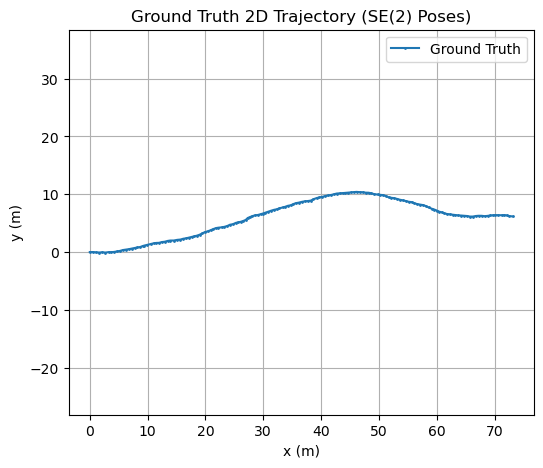

In [126]:
# Step 1: Construct the factor graph
fg = FactorGraph(gbp_settings)

# Number of poses = 1 initial + len(odometry_measurements)
n_poses = len(odometry_measurements) + 1

# 1. Add variable nodes with prior mean and cov
for i in range(n_poses):
    fg.add_var_node(
        dofs=3
    )

"""
,
prior_mean = torch.tensor([0., 0., 0.]),
prior_diag_cov= torch.tensor([1e9, 1e9, 1e9])
"""

# 2. Add an explicit strong prior factor (anchor) at pose 0
fg.add_factor(
    adj_var_ids=[0],
    measurement=torch.tensor([0., 0., 0.]),
    meas_model=UnaryMeasModel(
        diag_cov=anchor_cov_diag,
        target=torch.tensor([0., 0., 0.])
    )
)

# 3. Add odometry between factors
for i in range(n_poses - 1):
    fg.add_factor(
        adj_var_ids=[i, i + 1],
        measurement=odometry_measurements[i],
        meas_model=BetweenMeasModel(diag_cov=odom_cov_diag)
    )

# Optional: print summary
fg.print(brief=True)

# Step 2: Generate ground truth trajectory
gt_poses = [torch.tensor([0.0, 0.0, 0.0])]
for rel in odometry_measurements:
    gt_poses.append(pose_compose(gt_poses[-1], rel))
gt_array = torch.stack(gt_poses)

# Step 3: Plot ground truth trajectory
plt.figure(figsize=(6, 5))
plt.plot(gt_array[:, 0], gt_array[:, 1], '-o', label="Ground Truth", markersize=1)
plt.axis('equal')
plt.grid(True)
plt.title("Ground Truth 2D Trajectory (SE(2) Poses)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()


In [127]:
def plot_2d_poses(fg, gt=None, title="2D Pose-SLAM", show_arrows=True):
    """
    Plot current 2D pose beliefs from the factor graph.

    Args:
        fg: FactorGraph object
        gt: optional (n, 3) tensor of ground truth poses
        title: string for plot title
        show_arrows: whether to draw orientation arrows (default: True)
    """
    from IPython.display import clear_output

    est_poses = fg.belief_means().view(-1, 3).detach()

    clear_output(wait=True)
    plt.figure(figsize=(6, 5))

    # Estimated trajectory
    plt.plot(est_poses[:, 0], est_poses[:, 1], '-o', label='Estimated Poses', color='C0', markersize=1)

    if show_arrows:
        # Draw orientation arrows
        plt.quiver(
            est_poses[:, 0], est_poses[:, 1],
            torch.cos(est_poses[:, 2]), torch.sin(est_poses[:, 2]),
            angles='xy', scale_units='xy', scale=5, width=0.005, color='C0'
        )

    # Ground truth (optional)
    if gt is not None:
        plt.plot(gt[:, 0], gt[:, 1], '--', label='Ground Truth', color='gray')

    plt.axis('equal')
    plt.grid(True)
    plt.title(title)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.legend()
    plt.show()


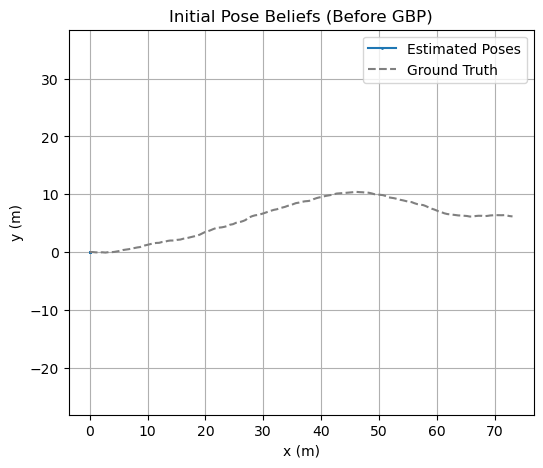

In [128]:
# Visualize initial pose beliefs before running GBP
plot_2d_poses(
    fg,
    gt=gt_array,  # Optional: remove this if no ground truth
    title="Initial Pose Beliefs (Before GBP)",
    show_arrows=False
)

### GBP optimization

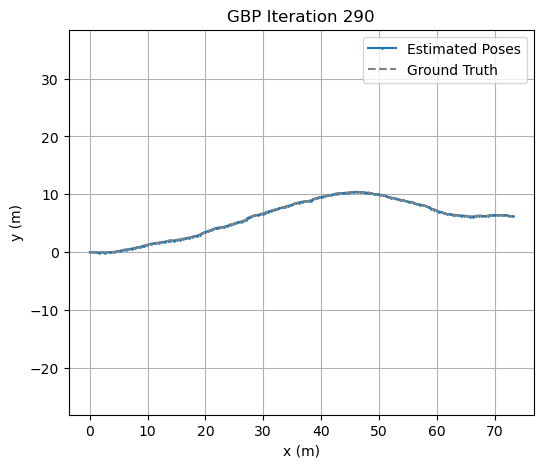

Iter 291  --- Energy 0.003712
Converged at iteration 292


In [129]:
fg.linearise_all_factors()

# Initial energy
prev_energy = fg.energy()
print(f"\nInitial Energy {prev_energy:.6f}")

energy_log = [prev_energy]
converged_count = 0
converged_tol = 1e-4
converged_required = 3

n_iters = 2000

for i in range(n_iters):
    fg.synchronous_iteration()

    # Optional: reset linearization count
    if i in fg.gbp_settings.reset_iters_since_relin:
        for f in fg.factors:
            f.iters_since_relin = 1

    # Compute energy
    curr_energy = fg.energy()
    energy_log.append(curr_energy)

    # Check convergence
    if abs(curr_energy - prev_energy) < converged_tol:
        converged_count += 1
        if converged_count >= converged_required:
            print(f"Converged at iteration {i+1}")
            break
    else:
        converged_count = 0


    prev_energy = curr_energy

    # Plot every several iterations
    if i % 10 == 0:
        plot_2d_poses(fg, gt=gt_array, title=f"GBP Iteration {i}", show_arrows=False)
        print(f"Iter {i+1:3d}  --- Energy {curr_energy:.6f}")


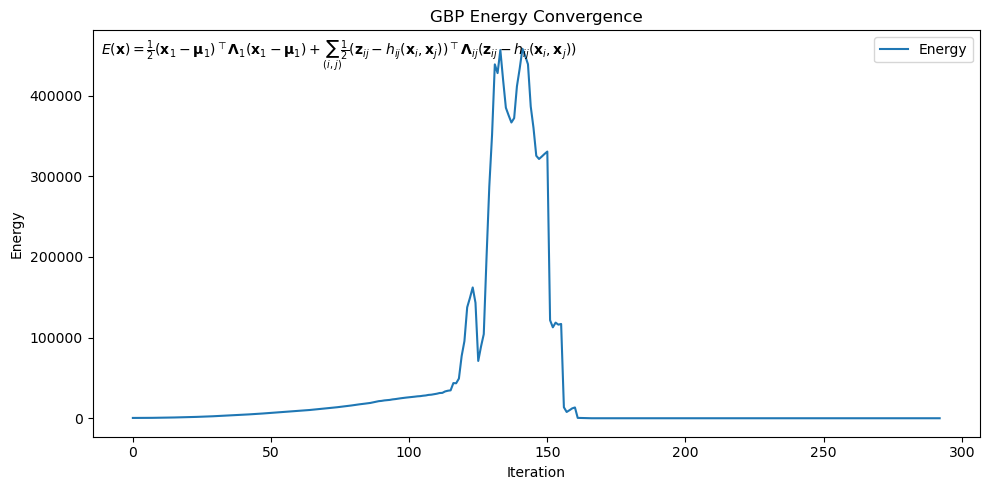

In [124]:
import matplotlib.pyplot as plt
import numpy as np

# Example: suppose you have energy_log as a list of energy values
# energy_log = [...]

# Convert to numpy for safety
energy_log = np.array(energy_log)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(energy_log, label="Energy")
ax.set_title("GBP Energy Convergence")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
ax.legend()

# Add LaTeX formula for energy function
formula = (r"$E(\mathbf{x}) =  \frac{1}{2} (\mathbf{x}_1 - \mathbf{\mu}_1)^\top \mathbf{\Lambda}_1 (\mathbf{x}_1 - \mathbf{\mu}_1)"
           r" + \sum_{(i,j)} \frac{1}{2} (\mathbf{z}_{ij} - h_{ij}(\mathbf{x}_i, \mathbf{x}_j))^\top \mathbf{\Lambda}_{ij} (\mathbf{z}_{ij} - h_{ij}(\mathbf{x}_i, \mathbf{x}_j))$")

# Add the formula text to the plot (bottom left corner)
ax.text(0.01, 0.98, formula, transform=ax.transAxes, fontsize=10, va='top', ha='left')

plt.tight_layout()
plt.show()


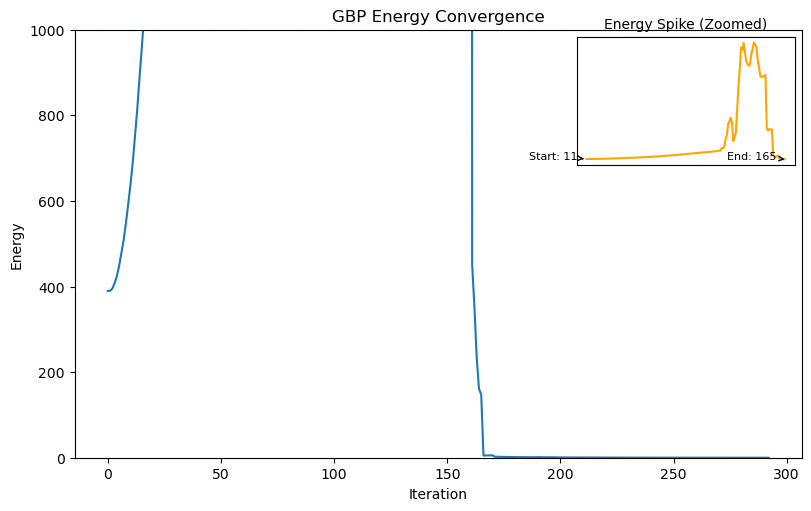

In [120]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# Threshold for outlier energy region
bar = 1000
energy_np = np.array(energy_log)

# Find indices where energy exceeds threshold
above_bar = np.where(energy_np > bar)[0]
if len(above_bar) > 0:
    inset_start = max(0, above_bar[0] - 5)  # Include a few points before
    inset_end = min(len(energy_np) - 1, above_bar[-1] + 5)  # Include a few points after
else:
    inset_start = inset_end = None

# Main chart: only show energy values below the threshold
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)
ax.plot(energy_np, label="Energy")
ax.axhline(y=bar, color='gray', linestyle='--', label=f"Threshold = {bar}")
ax.set_ylim([0, bar])  # Limit y-axis to better visualize normal values
ax.set_title("GBP Energy Convergence")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy")
ax.legend()

# Inset chart: zoom into the spike region
if inset_start is not None:
    axins = inset_axes(ax, width="30%", height="30%", loc="upper right")
    inset_x = np.arange(inset_start, inset_end + 1)
    inset_y = energy_np[inset_start:inset_end + 1]
    axins.plot(inset_x, inset_y, color="orange")
    axins.set_title("Energy Spike (Zoomed)", fontsize=10)

    # Mark the start and end point
    axins.annotate(f"Start: {inset_start}", xy=(inset_x[0], inset_y[0]),
                   xytext=(inset_x[0]-45, inset_y[0] + 100),
                   arrowprops=dict(arrowstyle="->", color='black'), fontsize=8)

    axins.annotate(f"End: {inset_end}", xy=(inset_x[-1], inset_y[-1]),
                   xytext=(inset_x[-1]-45, inset_y[-1] + 100),
                   arrowprops=dict(arrowstyle="->", color='black'), fontsize=8)

    axins.set_xticks([])
    axins.set_yticks([])

plt.show()


### LM optimization

In [ ]:
# Assume `fg` is an initialized FactorGraph with all variables and factors added

fg.linearise_all_factors()

# Initial lambda value and control parameters
lambda_lm = 1.0
max_iters = 500
energy_log = []

# Run LM iterations
for i in range(max_iters):
    energy = fg.energy()
    energy_log.append(energy)

    # Optional: plot every 10 iterations
    if i % 10 == 0:
        plot_2d_poses(fg, gt=gt_array, title=f"LM Iteration {i}", show_arrows=False)
        print(f"LM Iter {i+1:2d}  --- Energy {energy:.6f} --- Lambda {lambda_lm:.3e}")
    

    
    lambda_lm = fg.lm_step(lambda_lm)

# Final plot
plt.figure(figsize=(8, 4))
plt.plot(energy_log, marker='o')
plt.title("Energy during LM optimization")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.grid(True)
plt.show()


## test

In [ ]:
#@title Create measurements {vertical-output: true}

import torch
import math
import random

# Parameters
n_steps = 10
forward_mean = 0.5
lateral_std = 0.05
rot_std = 0.05

odometry_measurements = []

for _ in range(n_steps):
    forward = forward_mean + torch.randn(1).item() * 0.05
    lateral = torch.randn(1).item() * lateral_std
    dtheta = torch.randn(1).item() * rot_std
    odometry_measurements.append(torch.tensor([forward, lateral, dtheta]))


# Step 1: Construct the factor graph
fg = FactorGraph(gbp_settings)

# Number of poses = 1 initial + len(odometry_measurements)
n_poses = len(odometry_measurements) + 1

# 1. Add variable nodes with prior mean and cov
for i in range(n_poses):
    fg.add_var_node(
        dofs=3,
        prior_mean=torch.tensor([0., 0., 0.]),
        prior_diag_cov=prior_cov_diag
    )

# 2. Add an explicit strong prior factor (anchor) at pose 0
fg.add_factor(
    adj_var_ids=[0],
    measurement=torch.tensor([0., 0., 0.]),
    meas_model=UnaryMeasModel(
        diag_cov=anchor_cov_diag,
        target=torch.tensor([0., 0., 0.])
    )
)

# 3. Add odometry between factors
for i in range(n_poses - 1):
    fg.add_factor(
        adj_var_ids=[i, i + 1],
        measurement=odometry_measurements[i],
        meas_model=BetweenMeasModel(diag_cov=odom_cov_diag)
    )

# Optional: print summary
fg.print(brief=True)

# Step 2: Generate ground truth trajectory
gt_poses = [torch.tensor([0.0, 0.0, 0.0])]
for rel in odometry_measurements:
    gt_poses.append(pose_compose(gt_poses[-1], rel))
gt_array = torch.stack(gt_poses)

fg.linearise_all_factors()

# Initial energy
prev_energy = fg.energy()
print(f"\nInitial Energy {prev_energy:.6f}")

energy_log = [prev_energy]
converged_count = 0
converged_tol = 1e-6
converged_required = 3

n_iters = 200

for i in range(n_iters):
    fg.synchronous_iteration()

    # Optional: reset linearization count
    if i in fg.gbp_settings.reset_iters_since_relin:
        for f in fg.factors:
            f.iters_since_relin = 1

    # Compute energy
    curr_energy = fg.energy()
    energy_log.append(curr_energy)

    # Check convergence
    if abs(curr_energy - prev_energy) < converged_tol:
        converged_count += 1
        if converged_count >= converged_required:
            print(f"Converged at iteration {i+1}")
            break
    else:
        converged_count = 0

    prev_energy = curr_energy

    # Plot every several iterations
    if i % 5 == 0:
        plot_2d_poses(fg, gt=gt_array, title=f"GBP Iteration {i}", show_arrows=False)
        print(f"Iter {i+1:3d}  --- Energy {curr_energy:.6f}")
